<a href="https://colab.research.google.com/github/Murakami-Shoya/everyday_programming/blob/master/brain_decode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## memo

In [ ]:
test_raw = get_raw_each_subject(root_path + 'MURAKAI Syoya/', is_test=True, phd_binary=True)[0]
events = mne.find_events(test_raw, stim_channel='Photodiode-ch1', output='onset')
onset = events[0, 0]

Creating RawArray with float64 data, n_channels=13, n_times=9000
    Range : 0 ... 8999 =      0.000 ...    35.152 secs
Ready.
1 events found
Event IDs: [1]


In [ ]:
events # shape=(1, 3)

array([[2298,    0,    1]])

In [ ]:
test_raw.plot()

In [ ]:
onset

2298

In [ ]:
# onset前の5秒間だけスライス
# test_raw.get_data().shape   # (13, 9000)
# type(test_raw.get_data())   # numpy.ndarray

SFREQ = 256
base_line_data = test_raw.get_data()[:, onset-SFREQ*5 : onset]
base_line_data.shape

test_base_raw = mne.io.RawArray(base_line_data, info)


Creating RawArray with float64 data, n_channels=13, n_times=1280
    Range : 0 ... 1279 =      0.000 ...     4.996 secs
Ready.


In [ ]:
test_base_raw.plot() # 可視化してonsetの前が取り出せているか確認

In [ ]:
get_baseline(test_raw, dur_s=5) == test_base_raw

1 events found
Event IDs: [1]
Creating RawArray with float64 data, n_channels=13, n_times=1280
    Range : 0 ... 1279 =      0.000 ...     4.996 secs
Ready.


True

In [ ]:
type(test_raw)

mne.io.array.array.RawArray

Photodiodeがおかしいデータがある

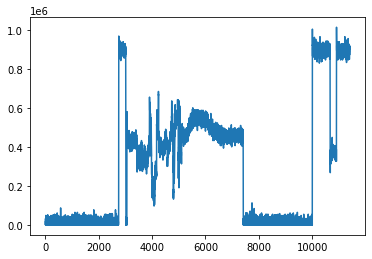

In [ ]:
# >onsetが2回
# >正しくフィルタリングできていない
# /content/drive/MyDrive/brain_tutorial/NODA Motoi/BBT-E12-AAB028-2023-01-11_14-17-37Photodiode.csv
# >5 4 (len(subjects), len(subjects[-1])
bad_phd = pd.read_csv('/content/drive/MyDrive/brain_tutorial/NODA Motoi/BBT-E12-AAB028-2023-01-11_14-17-37/Photodiode.csv')
plt.plot(bad_phd['Photodiode-ch1'])
plt.show()

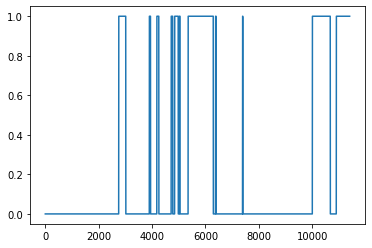

In [ ]:
filtered_phd = butter_lowpass_filter(bad_phd['Photodiode-ch1'], 6, SFREQ)
plt.plot(binary_phd(filtered_phd))
plt.show()

## やること



1.   Photodiodeで最初のベースラインのみの抽出

    立ち上がり前の5秒間
2.   ベースラインのみでデータセット作成(とりあえずraw)




In [1]:
pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 86.9 MB/s eta 0:00:00


In [2]:
import mne
import numpy as np

import mne
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
root_path = '/content/drive/MyDrive/brain_tutorial/'
subject_path_list = ['GOTO Mayu/',
                    'HIRUTA Ibuki/',
                    'INOUE Ibuki/',
                    'MURAKAI Syoya/',
                    'NODA Motoi/']
SFREQ = 256

In [4]:
# Create some dummy metadata
ch_names = ['EEG-CH1','EEG-CH2','EEG-CH3','EEG-CH4','EEG-CH5','EEG-CH6',
            'EEG-CH7','EEG-CH8','EEG-CH9','EEG-CH10','EEG-CH11','EEG-CH12','Photodiode-ch1']
ch_types = ['eeg'] * 12 + ['stim']
info = mne.create_info(ch_names=ch_names,sfreq=SFREQ,ch_types=ch_types)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: EEG-CH1, EEG-CH2, EEG-CH3, EEG-CH4, EEG-CH5, EEG-CH6, EEG-CH7, ...
 chs: 12 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 13
 projs: []
 sfreq: 256.0 Hz
>


### 1. ベースラインの抽出

#### 1.1 Photodiodeの二値化してイベントの取得

In [5]:
def binary_phd(raw_phd):
    b_phd = raw_phd.copy()
    phd_val_half_max = raw_phd.max()/2
    b_phd[raw_phd > phd_val_half_max] = 1
    b_phd[raw_phd <= phd_val_half_max] = 0
    return b_phd

In [6]:
###     orderの値でonsetを正しく検知させる      ###

import scipy.signal as signal

def butter_lowpass(lowcut, fs, order=4):
    '''バターワースローパスフィルタを設計する関数
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a


def butter_lowpass_filter(x, lowcut, fs, order=5):
    '''データにローパスフィルタをかける関数
    '''
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.filtfilt(b, a, x)
    return y


In [7]:
# 引数で渡された1トライアルあたりのeegとphotodiodeを結合してnp配列で返す

### is_test=Trueで二値化前のphotodiode返す

def concat_eeg_phd_to_raw(eeg_df, phd_df, person_path, is_binary=False):
    # df.drop(['corrected_time_stamp'],axis='columns',inplace=True)
    eeg_df.drop(["sequence"],axis='columns',inplace=True)
    eeg_df.drop(["battery"],axis='columns',inplace=True)
    eeg_df.drop(["flags"],axis='columns',inplace=True)

    # Event
    phd_df.drop(["sequence"],axis='columns',inplace=True)
    phd_df.drop(["battery"],axis='columns',inplace=True)
    phd_df.drop(["flags"],axis='columns',inplace=True)
    
    df = pd.concat([eeg_df, phd_df],axis=1)

    p = (len(df) - 9000) // 2
    q = (len(df) - 9000) % 2
    df = df[p:-(p+q)]
    
    #to numpy array
    np_data = np.array(df)
    np_data = np_data/1e6
    # print(data.shape)   #(9040, 13)
    np_data = np_data.transpose()
    # print(data.shape)   #(13, 9040)
    #ローパスフィルタ後に二値化
    if(is_binary):
        filtered_phd = butter_lowpass_filter(np_data[-1], 6, SFREQ)
        np_data[-1] = binary_phd(filtered_phd)

    raw = mne.io.RawArray(np_data,info)
    # ベースラインのみを抽出
    base_raw, is_unique_onset = get_baseline(raw, dur_s=5, sfreq=SFREQ)


    return base_raw, is_unique_onset

In [8]:
# 引数の被験者(ディレクトリ)一人分の全データをリストで返す(旧get_data_each_person)

###     is_test=True で1トライアルごとのデータに ###

def get_raw_each_subject(subject_path, is_test=False, phd_binary=True):  #できれば昇順(降順)にしたい
    trial_list = []
    for dir in os.listdir(subject_path): #1トライアルごと
        eeg_df, phd_df = None, None
        for file in os.listdir(subject_path + dir):  #フォルダの中のeeg, phdを探す
            if(file == 'EEG.csv'):
                # print(dir, file)
                eeg_df = pd.read_csv(subject_path + dir + '/' + file, header=0,index_col=0)
            elif(file == 'Photodiode.csv'):
                # print(dir, file)
                phd_df = pd.read_csv(subject_path + dir + '/' + file, header=0,index_col=0)

        trial_raw, is_unique_onset = concat_eeg_phd_to_raw(eeg_df, phd_df, root_path,is_binary=phd_binary)
        trial_list.append(trial_raw) # rawオブジェクトのリスト
        
        if(not(is_unique_onset)):
            print(subject_path+dir+'/Photodiode.csv')   # 異常なPhotodiodeはパスを表示

        if(is_test):    # testのときは時間短縮のため1トライアルデータだけ
            return trial_list

    return trial_list

In [9]:
def get_baseline(raw, dur_s, sfreq=SFREQ):
    events = mne.find_events(raw, stim_channel='Photodiode-ch1', output='onset')    #Photodiodeの立ち上がりを検知   

    onset = events[0, 0]    # onsetが異常でも最初のonsetで計算
    start = onset - sfreq*dur_s
    base_line_data = raw.get_data()[:, start:onset] #onset前の5秒間をスライス(ndarray)
    
    base_raw = mne.io.RawArray(base_line_data,info) #再度rawデータにする
    is_unique_onset = True

    if(events.shape[0]!=1):
        print("onsetの検知が1回以外")
        print("Photodiodeの値が異常")
        is_unique_onset = False

    return base_raw, is_unique_onset

In [10]:
subjects = []   #最終的なrawデータ(5人, 10トライアル, raw)
for subject_path in subject_path_list:  #被験者ごとに
    trial_raw_list = get_raw_each_subject(root_path + subject_path, is_test=False, phd_binary=True) #10トライアル分のrawデータのリスト
    subjects.append(trial_raw_list) #5人分にまとめる

print(len(subjects), len(subjects[-1]))  #5, 10

Creating RawArray with float64 data, n_channels=13, n_times=9000
    Range : 0 ... 8999 =      0.000 ...    35.152 secs
Ready.
1 events found
Event IDs: [1]
Creating RawArray with float64 data, n_channels=13, n_times=1280
    Range : 0 ... 1279 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=13, n_times=9000
    Range : 0 ... 8999 =      0.000 ...    35.152 secs
Ready.
1 events found
Event IDs: [1]
Creating RawArray with float64 data, n_channels=13, n_times=1280
    Range : 0 ... 1279 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=13, n_times=9000
    Range : 0 ... 8999 =      0.000 ...    35.152 secs
Ready.
1 events found
Event IDs: [1]
Creating RawArray with float64 data, n_channels=13, n_times=1280
    Range : 0 ... 1279 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=13, n_times=9000
    Range : 0 ... 8999 =      0.000 ...    35.152 secs
Ready.
1 events found
Event 

### 2. データセット化

In [11]:
!pip install moabb
!pip install braindecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 KB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 KB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyriemann: filename=pyriemann-0.4-py2.py3-none-any.whl size=105118 sha256=6803b29d66636bcd2b095d88618a97aca034fec48e2a8c5d65dacdf61831301a
  Stored in directory: /root/.cache/pip/wheels/1a/32/b8/6f844cc26ba42daee387f6aacc4b80f128233ff84703380967
Successfully built pyriemann
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 25.3 MB/s eta 0:00:00


In [12]:
# https://braindecode.org/stable/auto_examples/plot_regression.htmlをもとに作る


# def fake_regression_dataset(n_fake_recs, n_fake_chs, fake_sfreq, fake_duration_s):
#     datasets = []
#     for i in range(n_fake_recs):
#         train_or_eval = "eval" if i == 0 else "train"
#         raw, save_fname = create_mne_dummy_raw(
#             n_channels=n_fake_chs, n_times=fake_duration_s * fake_sfreq,
#             sfreq=fake_sfreq, savedir=None)
#         target = np.random.randint(0, 100, n_classes)   #ex.array([68])
#         if n_classes == 1:  # np.random.randintの返り値はnp.array()ってだけ
#             target = target[0]
#         fake_descrition = pd.Series(
#             data=[target, train_or_eval],
#             index=["target", "session"])
#         base_ds = BaseDataset(raw, fake_descrition, target_name="target")
#         datasets.append(base_ds)
#     dataset = BaseConcatDataset(datasets)
#     return dataset

In [13]:
from braindecode.datasets import BaseDataset, BaseConcatDataset

def create_dataset(subjects):
    dataset_list = []
    for sub_id, sub in enumerate(subjects):
        for i, trial_raw in enumerate(sub):
            train_or_eval = "eval" if i == 0 else "train"
            target = sub_id
            description = pd.Series(
                data=[target, train_or_eval],
                index=["target", "session"])
            
            base_ds = BaseDataset(raw=trial_raw, description=description, target_name="target")
            dataset_list.append(base_ds)

    dataset = BaseConcatDataset(dataset_list)
    return dataset

In [41]:
dataset = create_dataset(subjects)
dataset.description

,target,session
0,0,eval
1,0,train
2,0,train
3,0,train
4,0,train
5,0,train
6,0,train
7,0,train
8,0,train
9,0,train


In [42]:
x, y = dataset[-1]
print(x)
print(y)

[[-0.05505762]
 [-0.02159589]
 [-0.01619514]
 [-0.04946485]
 [-0.03510636]
 [-0.02992644]
 [-0.02129921]
 [-0.00722517]
 [-0.03582301]
 [-0.02820004]
 [-0.03325587]
 [-0.03018048]
 [ 0.        ]]
4


In [43]:
# dataset.datasets

window幅を変える

In [44]:
from braindecode.preprocessing import create_fixed_length_windows

input_window_samples = 5*SFREQ
window_stride_samples = 5*SFREQ

windows_dataset = create_fixed_length_windows(
    dataset,
    start_offset_samples=0,
    stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=window_stride_samples,
    drop_last_window=False,
    drop_bad_windows=True,
)

windows_dataset.get_metadata()

Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from prel

/usr/local/lib/python3.8/dist-packages/braindecode/preprocessing/windowers.py:602: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1280 original time points ...
0 bad epochs dropped

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,session
0,0,0,1280,0,eval
0,0,0,1280,0,train
0,0,0,1280,0,train
0,0,0,1280,0,train
0,0,0,1280,0,train
0,0,0,1280,0,train
0,0,0,1280,0,train
0,0,0,1280,0,train
0,0,0,1280,0,train
0,0,0,1280,0,train


sleepデータの例と一緒
    
    i_window_in_trial	i_start_in_trial	i_stop_in_trial	target	subject	recording
    0	0	2427000	2430000	0	0	2

    1	1	2430000	2433000	0	0	2

    2	2	2433000	2436000	0	0	2

    3	3	2436000	2439000	0	0	2

    4	4	2439000	2442000	0	0	2

    5	5	2442000	2445000	0	0	2


In [45]:
x, y, ind = windows_dataset[-1]
print('x:', x)
print('y:', y)
print('ind:', ind)

Using data from preloaded Raw for 1 events and 1280 original time points ...
x: [[-0.05504785 -0.05504796 -0.0550492  ... -0.05505816 -0.05506148
  -0.05505762]
 [-0.02159138 -0.02159509 -0.02160025 ... -0.02161397 -0.02160893
  -0.02159589]
 [-0.01622701 -0.01623251 -0.01623836 ... -0.01620221 -0.01620572
  -0.01619514]
 ...
 [-0.033253   -0.0332428  -0.03323789 ... -0.03325271 -0.03325507
  -0.03325587]
 [-0.03014845 -0.03013785 -0.03013459 ... -0.03018104 -0.03018329
  -0.03018047]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
y: 4
ind: [0, 0, 1280]


### 前処理

In [46]:
from braindecode.preprocessing import preprocess, Preprocessor, scale
from sklearn.preprocessing import scale as standard_scale

preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)])

Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...
Using data from preloaded Raw for 1 events and 1280 original time points ...

### 学習データと評価データ分け

In [47]:
splits = windows_dataset.split('session')
train_set, valid_set = splits["train"], splits["eval"]

### シーケンスで学習

In [48]:
from braindecode.samplers import SequenceSampler

n_windows = 3  # Sequences of 3 consecutive windows
n_windows_stride = 3  # Maximally overlapping sequences

train_sampler = SequenceSampler(train_set.get_metadata(), n_windows, n_windows_stride)
valid_sampler = SequenceSampler(valid_set.get_metadata(), n_windows, n_windows_stride)

# Print number of examples per class
print('Training examples: ', len(train_sampler))
print('Validation examples: ', len(valid_sampler))

Training examples:  15
Validation examples:  1


In [49]:
type(train_sampler)

braindecode.samplers.base.SequenceSampler

In [50]:
# Use label of center window in the sequence
from numbers import Integral

# Use label of center window in the sequence
def get_center_label(x):
    if isinstance(x, Integral):
        return x
    return x[np.ceil(len(x) / 2).astype(int)] if len(x) > 1 else x


train_set.target_transform = get_center_label
valid_set.target_transform = get_center_label

In [51]:
#train_setの形式
# 5*SFREQのとき45のタプル
#(raw, y, [i_window_in_trial	i_start_in_trial	i_stop_in_trial])の形

In [52]:
# from sklearn.utils import compute_class_weight

# y_train = [train_set[idx][1] for idx in train_sampler]
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [53]:
# import numpy as np
# from sklearn.utils import compute_class_weight

# y_train = [train_set[idx][1][1] for idx in train_sampler]
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [54]:
train_set[0][0].shape

(13, 1280)

In [55]:
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018, TimeDistributed

cuda = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
set_random_seeds(seed=31, cuda=cuda)

n_classes = 5
# Extract number of channels and time steps from dataset
n_channels, input_size_samples = train_set[0][0].shape

feat_extractor = SleepStagerChambon2018(
    n_channels,
    SFREQ,
    n_classes=n_classes,
    input_size_s=input_size_samples / SFREQ,
    return_feats=True
)

model = nn.Sequential(
    TimeDistributed(feat_extractor),  # apply model on each 30-s window
    nn.Sequential(  # apply linear layer on concatenated feature vectors
        nn.Flatten(start_dim=1),
        nn.Dropout(0.5),
        nn.Linear(feat_extractor.len_last_layer * n_windows, n_classes)
        # nn.SoftMax(dim=1)
    )
)

# Send model to GPU
if cuda:
    model.cuda()

/usr/local/lib/python3.8/dist-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


In [56]:
print(n_channels, input_size_samples)

13 1280


In [57]:
from sklearn.preprocessing import OneHotEncoder

train_y = train_set.get_metadata()['target'].values.reshape(-1, 1)
enc = OneHotEncoder( sparse=False )

# 結果(ndarray)
y = enc.fit_transform(train_y)
tensor_y = torch.from_numpy(y)
tensor_y

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0

In [58]:
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring
from braindecode import EEGClassifier

lr = 1e-3
batch_size = 8
n_epochs = 10

train_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bal_acc',
    lower_is_better=False)
valid_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bal_acc',
    lower_is_better=False)
callbacks = [
    ('train_bal_acc', train_bal_acc),
    ('valid_bal_acc', valid_bal_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    # criterion__weight=torch.Tensor(class_weights).to(device),
    optimizer=torch.optim.Adam,
    # iterator_train__shuffle=False,
    # iterator_train__sampler=train_sampler,
    # iterator_valid__sampler=valid_sampler,
    # train_split=predefined_split(valid_set),  # using valid_set for validation
    train_split=None,
    # optimizer__lr=lr,
    # batch_size=batch_size,
    # callbacks=callbacks,
    # device=device
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch     dur
-------  ------
      1  0.0004
      2  0.0003
      3  0.0002
      4  0.0003
      5  0.0002
      6  0.0002
      7  0.0002
      8  0.0002
      9  0.0002
     10  0.0002


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Sequential(
    (0): TimeDistributed(
      (module): SleepStagerChambon2018(
        (spatial_conv): Conv2d(1, 13, kernel_size=(13, 1), stride=(1, 1))
        (feature_extractor): Sequential(
          (0): Conv2d(1, 8, kernel_size=(1, 128), stride=(1, 1), padding=(0, 64))
          (1): Identity()
          (2): ReLU()
          (3): MaxPool2d(kernel_size=(1, 32), stride=(1, 32), padding=0, dilation=1, ceil_mode=False)
          (4): Conv2d(8, 8, kernel_size=(1, 128), stride=(1, 1), padding=(0, 64))
          (5): Identity()
          (6): ReLU()
          (7): MaxPool2d(kernel_size=(1, 32), stride=(1, 32), padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (1): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=312, out_features=5, bias=True)
    )
  ),
)

In [ ]:
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring
from braindecode import EEGClassifier

lr = 1e-3
batch_size = 8
n_epochs = 10

train_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bal_acc',
    lower_is_better=False)
valid_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bal_acc',
    lower_is_better=False)
callbacks = [
    ('train_bal_acc', train_bal_acc),
    ('valid_bal_acc', valid_bal_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    # criterion__weight=torch.Tensor(class_weights).to(device),
    optimizer=torch.optim.Adam,
    # iterator_train__shuffle=False,
    # iterator_train__sampler=train_sampler,
    # iterator_valid__sampler=valid_sampler,
    # train_split=predefined_split(valid_set),  # using valid_set for validation
    train_split=None,
    optimizer__lr=lr,
    # batch_size=batch_size,
    # callbacks=callbacks,
    device=device
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(train_set, y=y, epochs=n_epochs)

In [ ]:
clf.predict(valid_set)

ValueError: ignored